In [10]:
import data
import torch
import sde
import policy
import numpy as np
from torch.optim import SGD, RMSprop, Adagrad, AdamW, lr_scheduler, Adam
from torch.utils.tensorboard import SummaryWriter
from torch_ema import ExponentialMovingAverage
import matplotlib.pyplot as plt
import runner
from runner import Runner
import util



def build_optimizer_ema_sched(opt, policy):
    direction = policy.direction

    optim_name = {
        'Adam': Adam,
        'AdamW': AdamW,
        'Adagrad': Adagrad, 
        'RMSprop': RMSprop,
        'SGD': SGD,
    }.get(opt.optimizer)

    optim_dict = {
            "lr": opt.lr_f if direction=='forward' else opt.lr_b,
            'weight_decay':opt.l2_norm,
    }
    if opt.optimizer == 'SGD':
        optim_dict['momentum'] = 0.9

    optimizer = optim_name(policy.parameters(), **optim_dict)
    ema = ExponentialMovingAverage(policy.parameters(), decay=0.99)
    if opt.lr_gamma < 1.0:
        sched = lr_scheduler.StepLR(optimizer, step_size=opt.lr_step, gamma=opt.lr_gamma)
    else:
        sched = None

    return optimizer, ema, sched

class arg:
    samp_bs = 50
    problem_name = 'Sin'#'Scurve'
    
    inner_itr = 2
    mask_update_itr = 1

    condition = False # if False, it's exactly same with origin code


    device = 'cuda:0'
    t0 = 0
    T=1
    interval=100
    sde_type = 've'
    noise_type = 'gaussian'
    sigma_min = 0.01
    sigma_max = 0.3
    forward_net = 'toy'
    backward_net = 'toy'
    
    hidden_nodes = 56
    blocks = 2


    optimizer = 'AdamW'
    lr = 4e-3
    lr_f = 4e-3
    lr_b = 4e-3
    lr_gamma = 0.8
    lr_step = 500
    l2_norm = 1e-3
    train_method = 'joint'
    seed = 123
    num_itr = 1000
    eval_itr = 100
    

    

opt = arg()
if opt.problem_name == 'Sin':
    opt.data_dim = [50]
elif opt.problem_name == 'Scurve':
    opt.data_dim = [2]   



In [11]:
with torch.cuda.device(opt.device):
    run = Runner(opt)

    run.sb_joint_train(opt)

build boundary distribution...
build base sde...
build forward policy...
number of parameters is 32866
build backward policy...
number of parameters is 32866
[SB joint] train_it 1/1000 | lr:4.00e-03 | loss:60.9687 | time:0:00:00.23
[SB joint] train_it 2/1000 | lr:4.00e-03 | loss:60.6072 | time:0:00:00.44
[SB joint] train_it 3/1000 | lr:4.00e-03 | loss:60.5263 | time:0:00:00.63
[SB joint] train_it 4/1000 | lr:4.00e-03 | loss:60.3369 | time:0:00:00.82
[SB joint] train_it 5/1000 | lr:4.00e-03 | loss:59.7069 | time:0:00:01.02
[SB joint] train_it 6/1000 | lr:4.00e-03 | loss:59.3886 | time:0:00:01.21
[SB joint] train_it 7/1000 | lr:4.00e-03 | loss:59.1402 | time:0:00:01.40
[SB joint] train_it 8/1000 | lr:4.00e-03 | loss:58.8315 | time:0:00:01.60
[SB joint] train_it 9/1000 | lr:4.00e-03 | loss:57.9590 | time:0:00:01.79
[SB joint] train_it 10/1000 | lr:4.00e-03 | loss:56.8149 | time:0:00:01.98
[SB joint] train_it 11/1000 | lr:4.00e-03 | loss:55.8445 | time:0:00:02.18
[SB joint] train_it 12/100

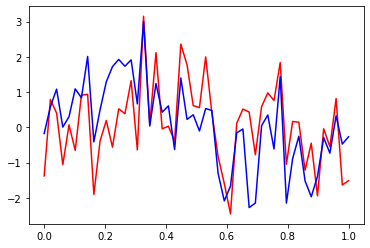

In [12]:

# raw test of the backward_network
with torch.no_grad():
    ts      = run.ts
    policy_b = run.z_b
    xs_b, _, _ =run.dyn.sample_traj(ts, policy_b, save_traj=True)
plt.plot(np.linspace(0,1,opt.data_dim[0]),xs_b[0,99,:].cpu(),'red') 
plt.plot(np.linspace(0,1,opt.data_dim[0]),xs_b[0,0,:].cpu(),'blue')

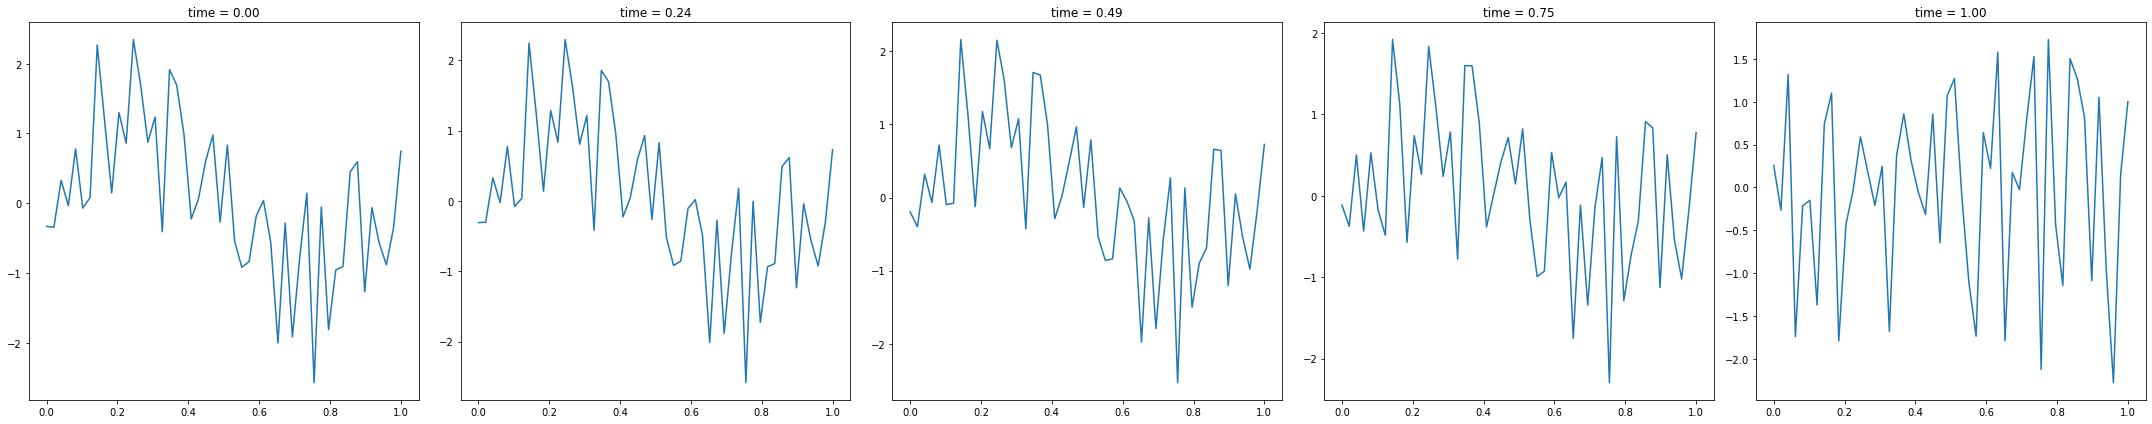

In [17]:
# for 1-d sin visulization
with torch.no_grad():
    ts      = run.ts
    policy_b = run.z_b
    xs_b, _, _ =run.dyn.sample_traj(ts, policy_b, save_traj=True)
direction='backward'
traj = xs_b
n_snapshot = 5
lims = [-2.6, 2.6]

total_steps = opt.interval#traj.shape[1]
sample_steps = np.linspace(0, total_steps-1, n_snapshot).astype(int)
fig, axs = plt.subplots(1, n_snapshot)
fig.set_size_inches(n_snapshot*6, 6)
color = 'salmon' if direction=='forward' else 'royalblue'

x = np.linspace(0,1,opt.data_dim[0])

for ax, step in zip(axs, sample_steps):

    # ax.scatter(traj[:,step,0],traj[:,step,1], s=5, color=color)
    # ax.scatter(x,traj[0,step,:], s=5, color=color)
    ax.plot(x,traj[0,step,:])


    # ax.set_xlim(*lims)
    # ax.set_ylim(*lims)
    ax.set_title('time = {:.2f}'.format(step/(total_steps-1)*opt.T))
fig.tight_layout()

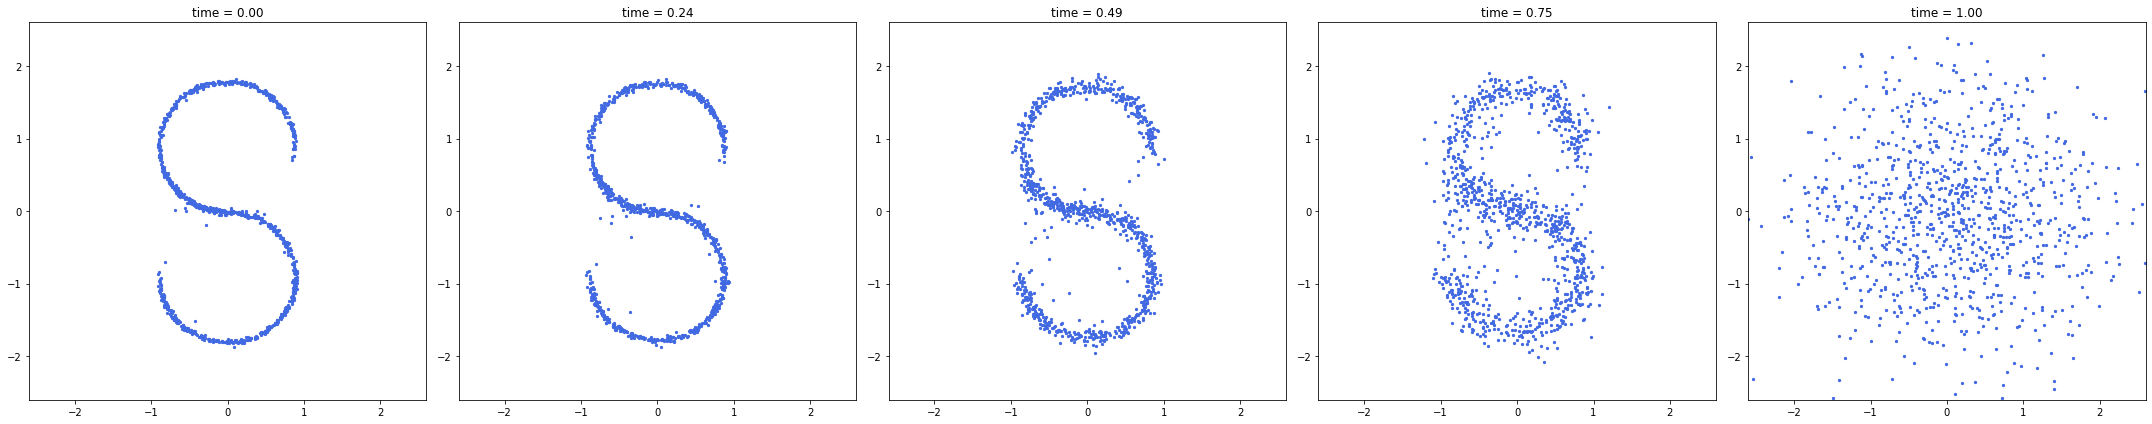

In [7]:
# for S-scurve visulization
with torch.no_grad():
    ts      = run.ts
    policy_b = run.z_b
    xs_b, _, _ =run.dyn.sample_traj(ts, policy_b, save_traj=True)
direction='backward'
traj = xs_b
n_snapshot = 5
lims = [-2.6, 2.6]

total_steps = traj.shape[1]
sample_steps = np.linspace(0, total_steps-1, n_snapshot).astype(int)
fig, axs = plt.subplots(1, n_snapshot)
fig.set_size_inches(n_snapshot*6, 6)
color = 'salmon' if direction=='forward' else 'royalblue'


for ax, step in zip(axs, sample_steps):

    ax.scatter(traj[:,step,0],traj[:,step,1], s=5, color=color)

    ax.set_xlim(*lims)
    ax.set_ylim(*lims)
    ax.set_title('time = {:.2f}'.format(step/(total_steps-1)*opt.T))
fig.tight_layout()